Для запуска необходимо иметь 5 файлов в папке с блокнотом
1. cpfX.py
2. read_bases.py
3. hapi.py
4. VIRAPROFILE.txt
5. Файл с линиями поглощения

## 0. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from read_bases import *
from scipy import constants
import pandas as pd
from misc_functions import * # Пока что тут константы
from tqdm import tqdm # for loop time
from hapi import partitionSum
import netCDF4 as netcdf

HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

## 1. Inputs

### 1.1 Set up directories

In [2]:
DATABASE_CO2 = 'hot_ames' # 'hitran' # 'ames', 'bezard'
FILENAME_CO2 = 'co2hitemp.allmixed.296K-1000K.cut' # '65f81198.par' # 'Ames-2016.natural.co2.296k.list.long.format.dat', bezard_hotco2_1mu_cdsd.dat'
DATABASE_H2O = 'hitran' # 'hitran' # 'ames', 'bezard'
FILENAME_H2O = '6689a056.par' # '65f81198.par' # 'Ames-2016.natural.co2.296k.list.long.format.dat', bezard_hotco2_1mu_cdsd.dat'
DATABASE_HDO = 'hitran' # 'hitran' # 'ames', 'bezard'
FILENAME_HDO = '6689a056.par' # '65f81198.par' # 'Ames-2016.natural.co2.296k.list.long.format.dat', bezard_hotco2_1mu_cdsd.dat'
FILENAME_H2O_CONT = 'databases/absco-ref_wv-mt-ckd.nc'

PROFILE_CO2 = 'bezard' # 'voigt'
PROFILE_H2O = 'foreign_cont_MTCKD' # foreign_cont foreign_cont_sep foreign_cont_MTCKD

PROFILE_FILENAME = 'VIRAPROFILE.txt'
AEROSOL_FILENAME = 'venusclouds_75_Haus16.txt'
LINES_PATH = 'databases/'
INPUT_PATH = 'input/'
OUTPUT_PATH = 'gas_ext/'
OUTPUT_PATH_ABS = 'absorbtion_cross_sections/'

### 1.2 Set up wavenumber grid

In [3]:
step = 0.05
step_txt = str(step).replace('.', '')
cutoff_co2 = 250
cutoff_h2o = 180
cutoff_cont_h2o = 25
effect_limit = max(cutoff_co2, cutoff_h2o) # cm^-1
left_limit = 9600 # 9650 # 9650 # 9400 # cm^-1
right_limit = 11000 # 9700 # 10550 #  9900 # 11000
span = right_limit - left_limit

In [4]:
#wavenumber range for calculating profiles with cut-off ±250 cm^-1
w = np.arange(left_limit - effect_limit, right_limit + effect_limit + step, step)
print(w.shape)
w

(38001,)


array([ 9350.        ,  9350.05      ,  9350.1       , ...,
       11249.89999997, 11249.94999997, 11249.99999997])

### 1.3 Hyperparameters 

In [5]:
ic = 0.0 # CO2 continuum coefficient
ihdo = 1 # HDO = 1 => H2O/HDO = 128 SMOW; HDO = 0 => no HDO
iw = 28  # H2O volume mixing ratio (VMR = Nh2o/Nco2)
vmrco2 = 0.965
vmrh2o = iw * 1e-6
vmrhdo = ihdo * vmrh2o * 128 * 3.1153e-4

if ihdo == 0:
    vmrh2o = iw * 1e-6 * (1 + 128 * 3.1153e-4)

T_ref_co2 = 296
T_ref_h2o = 296

## 2. Profile of the atmoshpere

In [6]:
pressure, height, concentration, temperature = np.loadtxt(INPUT_PATH + PROFILE_FILENAME, skiprows = 1, unpack=True)

height_corrected = np.arange(-3, 101, 1)
pressure_corrected = np.exp(interp1d(height, np.log(pressure), kind='linear', fill_value='extrapolate')(height_corrected))
concentration_corrected = np.exp(interp1d(height, np.log(concentration), kind='linear', fill_value='extrapolate')(height_corrected))
temperature_corrected = interp1d(height, temperature, kind='linear', fill_value='extrapolate')(height_corrected)

atm = np.column_stack([
    pressure_corrected, 
    height_corrected, 
    concentration_corrected, 
    temperature_corrected
])

In [7]:
len(atm)

104

## 3. CO2 cross-sections

### 3.1 Load spectral lines

In [8]:
if DATABASE_CO2 == 'hitran':
    line_data = read_hitran2012(LINES_PATH + FILENAME_CO2)
elif DATABASE_CO2 == 'ames':
    line_data = read_ames(LINES_PATH + FILENAME_CO2)
elif DATABASE_CO2 == 'hot_ames':
    line_data = read_hot_ames(LINES_PATH + FILENAME_CO2)
elif DATABASE_CO2 == 'bezard':
    line_data = read_bezard(LINES_PATH + FILENAME_CO2)

df = pd.DataFrame(line_data)
df.shape

Reading "databases/co2hitemp.allmixed.296K-1000K.cut" ...


(3348092, 8)

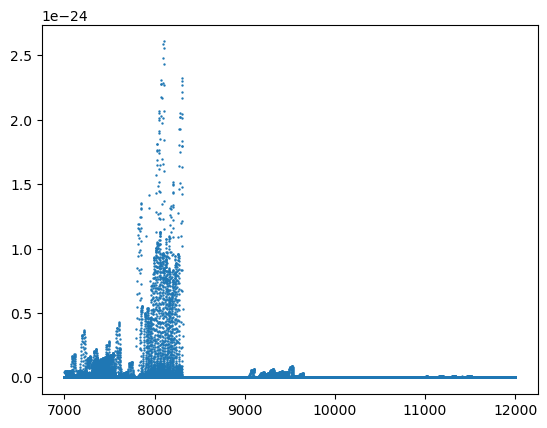

In [9]:
plt.scatter(df.linecenter, df.S, s=0.5)
plt.show();

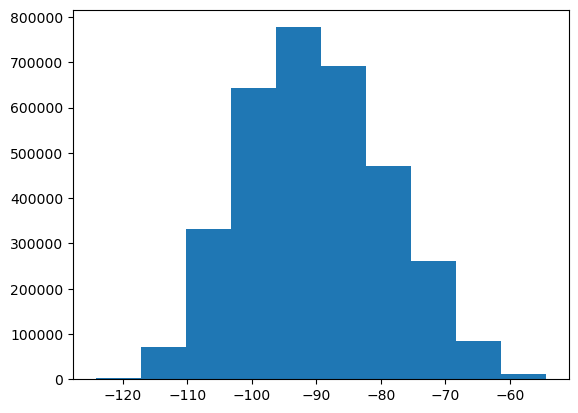

In [10]:
plt.hist(np.log(df.S))
plt.show();

### 3.2 Get required range

In [11]:
wavenum_mask = (
    (line_data['linecenter'] >= left_limit - effect_limit) & 
    (line_data['linecenter'] <= right_limit + effect_limit)
)

iso_mask = np.ones(len(line_data['I']))

intensity_mask = line_data['S'] > np.exp(-75)

mask = np.where(iso_mask * wavenum_mask * intensity_mask == 1)[0]

m = len(mask)
m

77041

In [12]:
E = line_data['Epp'][mask]
intensity_ref = line_data['S'][mask]
iso = line_data['I'][mask]

pshift = line_data['delta'][mask]
n = line_data['N'][mask]

gamma_self = np.array(line_data['gamma-self'])[mask]
gamma_air = line_data['gamma-air'][mask] # * 1.5 

### 3.3 Molar mass

In [13]:
np.unique(iso)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [14]:
molar_mass_reference = np.array([43.989830, 44.993185, 45.994076, 44.994045,
                                 46.997431, 45.997400, 47.998320, 46.998291,
                                 45.998262, 49.001675, 48.001646, 47.001618])

abundance_reference = np.array([9.84204e-1, 1.10574e-2, 3.94707e-3, 7.33989e-4,
                                4.43446e-5, 8.24623e-6, 3.95734e-6, 1.47180e-6, 
                                1.36847e-7, 4.44600e-8, 1.65354e-8, 1.53745e-9])

mol_mass = []
abundance = []
for j in range(m):
    mol_mass.append(molar_mass_reference[iso[j]-1])
    abundance.append(abundance_reference[iso[j]-1])

In [15]:
delta_nu = np.absolute(w - np.array(line_data['linecenter'])[mask][50000])
chi = np.ones(len(w))

mask1 = delta_nu < 3
mask2 = (delta_nu >= 3) & (delta_nu < 20)
mask3 = (delta_nu >= 20) & (delta_nu < 120)
mask4 = (delta_nu >= 120)
mask5 = delta_nu >= cutoff_co2

chi[mask2] = 1.2214*np.exp(-delta_nu[mask2]/15)
chi[mask3] = 0.3477*np.exp(-delta_nu[mask3]/260)
chi[mask4] = 0.7276*np.exp(-delta_nu[mask4]/100)
chi[mask5] = 0

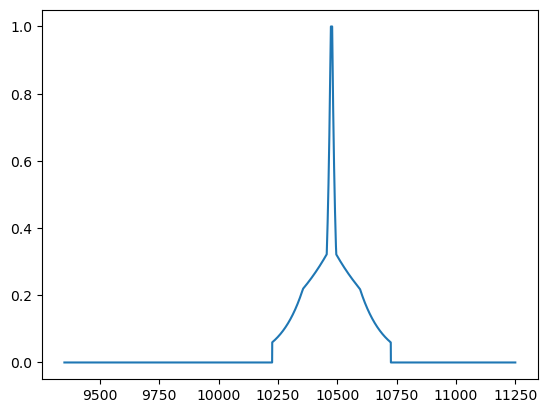

In [16]:
plt.plot(w, chi)

### 3.4 Calculating cross-sections

In [17]:
spectrum_co2 = []

#Loop for viraprofile of temperature and pressure
for l in tqdm(range(len(atm))):
    nu = np.array(line_data['linecenter'])[mask]
    p_self = atm[l, 0]
    T = atm[l, 3]
    p = atm[l, 0]

    wD = doppler_fwhm(nu, T, mol_mass) #calculating half-width at half-maximum for doppler
    wL = lorenz_fwhm(p, T, 350, gamma_self, gamma_air, p_self, n) #for Lorentz

    #Calculating the spectrum of cross-sections
    sigma = np.zeros(w.size)
    for k in np.arange(0,m):
        #Calculating line strength
        Q = partitionSum(2, iso[k], T_ref_co2) #uses hapi module to calculate partition sums
        Qt = partitionSum(2, iso[k], T)
        intensity = abundance[k] * intensity_ref[k]*Q/Qt*(np.exp(-RADCN2*E[k]/T)/np.exp(-RADCN2*E[k]/T_ref_co2))*(1 - np.exp(-RADCN2*nu[k]/T))/(1 - np.exp(-RADCN2*nu[k]/T_ref_co2))
        ## ======================================================
        
        nu[k] = nu[k] + pshift[k] * p

        delta_nu = np.absolute(w - nu[k])

        #chi facotor
        chi = np.ones(len(w))

        if PROFILE_CO2 == 'bezard':
            
            mask1 = (delta_nu >= 3) & (delta_nu < 20)
            mask2 = (delta_nu >= 20) & (delta_nu < 120)
            mask3 = (delta_nu >= 120) & (delta_nu < cutoff_co2)
    
            chi[mask1] = 1.2214*np.exp(-delta_nu[mask1]/15)
            chi[mask2] = 0.3477*np.exp(-delta_nu[mask2]/260)
            chi[mask3] = 0.7276*np.exp(-delta_nu[mask3]/100)    
        
        # Применение cutoff
        
        chi[delta_nu >= cutoff_co2] = 0

        #Calculating voight profiles with Humlıcek approximation

        y = wL[k] / wD[k]
        x = (w-nu[k]) / wD[k]

        scale = 1/(wD[k]*np.sqrt(np.pi))

        profile = compute_profile(x, y)*scale
        profile = profile * chi

        # Calculating cross_sections
        cross_section = profile*intensity
        cross_section = cross_section.real

        sigma += cross_section

    spectrum_co2.append(sigma)

100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [2:07:00<00:00, 73.27s/it]


In [18]:
spectrum_co2 = np.array(spectrum_co2)
output = np.vstack((w, spectrum_co2))
np.savetxt(OUTPUT_PATH_ABS + f'abs_cross_section_CO2_{DATABASE_CO2}_{PROFILE_CO2}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', output, delimiter=',')

## 4. H2O cross-sections

### 4.1 Load spectral lines

In [17]:
if DATABASE_H2O == 'hitran':
    line_data = read_hitran2012(LINES_PATH + FILENAME_H2O)
elif DATABASE_H2O == 'ames':
    line_data = read_ames(LINES_PATH + FILENAME_H2O)
elif DATABASE_H2O == 'bezard':
    line_data = read_bezard(LINES_PATH + FILENAME_H2O)
    
continuum_data = netcdf.Dataset(FILENAME_H2O_CONT)

# df = pd.DataFrame(line_data)
# df.shape

Reading "databases/6689a056.par" ...


In [18]:
# plt.scatter(df.linecenter, df.S, s=0.5)
# plt.show();

### 4.2 Get required range

In [19]:
wavenum_mask = (
    (line_data['linecenter'] >= left_limit - effect_limit) & 
    (line_data['linecenter'] <= right_limit + effect_limit)
)

iso_mask = line_data['I'] == 1

mask = np.where(iso_mask * wavenum_mask == 1)[0]

m = len(mask)
m

26849

In [20]:
iso = line_data['I'][mask]

E = line_data['Epp'][mask]
intensity_ref = line_data['S'][mask]


pshift = line_data['delta'][mask]
n = line_data['N'][mask]

gamma_self = np.array(line_data['gamma-self'])[mask]
gamma_air = line_data['gamma-air'][mask] * 1.5 

### 4.3 Molar mass

In [21]:
np.unique(iso)

array([1])

In [22]:
molar_mass_reference = np.array([18.010565, 20.014811, 19.014780, 19.016740,
                                 21.020985, 20.020956, 20.022915])

mol_mass = []
for j in range(m):
    mol_mass.append(molar_mass_reference[iso[j]-1])

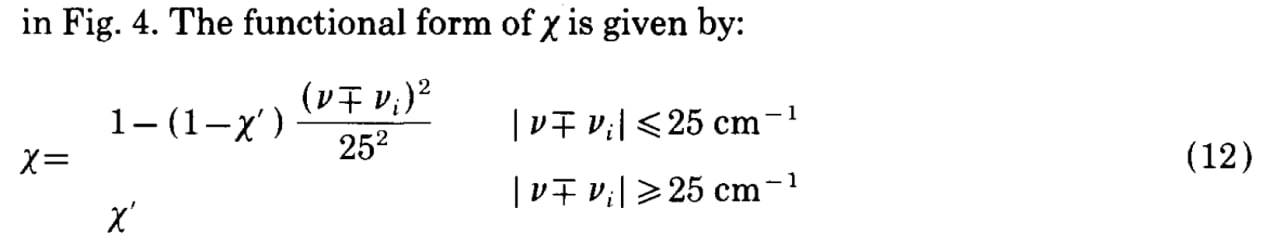

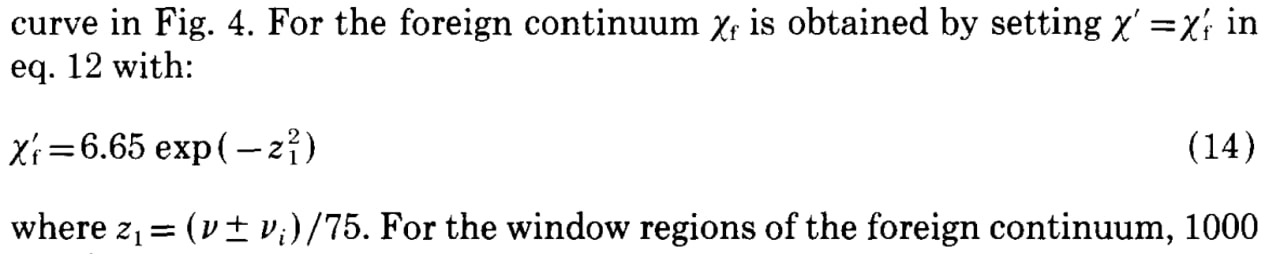

In [23]:
delta_nu = np.absolute(w - np.array(line_data['linecenter'])[mask][20000])

chi_f = 6.65 * np.exp(-delta_nu**2/75**2)

chi = np.ones(len(w))

mask1 = delta_nu < cutoff_cont_h2o
mask2 = delta_nu >= cutoff_cont_h2o

chi[mask1] = 1 - (1 - chi_f[mask1])*delta_nu[mask1]**2/25**2
chi[mask2] = chi_f[mask2]

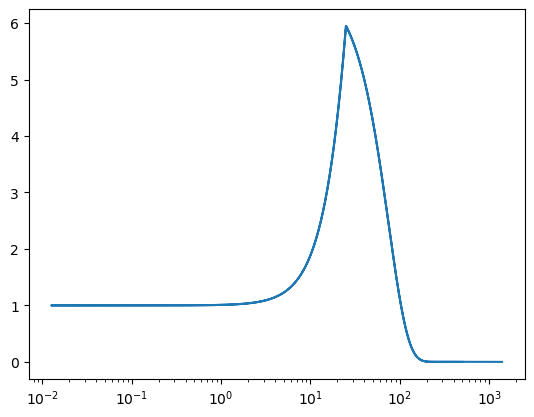

In [24]:
plt.plot(delta_nu, chi)
# plt.xlim([-200,200])
plt.xscale('log')
# plt.yscale('log')

### 4.4 Calculating cross-sections

In [24]:
spectrum_h2o = []

#Loop for viraprofile of temperature and pressure
for l in tqdm(range(len(atm))):
    nu = np.array(line_data['linecenter'])[mask]
    p_self = atm[l, 0]
    T = atm[l, 3]
    p = atm[l, 0]

    wD = doppler_fwhm(nu, T, mol_mass) #calculating half-width at half-maximum for doppler
    wL = lorenz_fwhm(p, T, 296, gamma_self, gamma_air, p_self, n) #for Lorentz

    #Calculating the spectrum of cross-sections
    sigma = np.zeros(w.size)
    
    for k in np.arange(0,m):
        #Calculating line strength
        Q = partitionSum(2, iso[k], T_ref_h2o) #uses hapi module to calculate partition sums
        Qt = partitionSum(2, iso[k], T)
        intensity = intensity_ref[k]*Q/Qt*(np.exp(-RADCN2*E[k]/T)/np.exp(-RADCN2*E[k]/T_ref_h2o))*(1 - np.exp(-RADCN2*nu[k]/T))/(1 - np.exp(-RADCN2*nu[k]/T_ref_h2o))
        ## ======================================================
    
        nu[k] = nu[k] + pshift[k] * p
        
        delta_nu = np.absolute(w - nu[k])

        #chi facotor
        
        chi = np.ones(len(w))
        
        if PROFILE_H2O == 'foreign_cont':
            
            chi_f = 6.65 * np.exp(-delta_nu**2/75**2)
            
            mask1 = delta_nu < cutoff_cont_h2o
            mask2 = delta_nu >= cutoff_cont_h2o
            
            chi[mask1] = 1 - (1 - chi_f[mask1])*delta_nu[mask1]**2/25**2
            chi[mask2] = chi_f[mask2]
        
        # Применение cutoff
        
        chi[delta_nu >= cutoff_h2o] = 0

        #Calculating voight profiles with Humlıcek approximation

        y = wL[k] / wD[k]
        x = (w-nu[k]) / wD[k]

        scale = 1/(wD[k]*np.sqrt(np.pi))

        profile = compute_profile(x, y)*scale
        profile = profile * chi

        # Calculating cross_sections
        cross_section = profile*intensity
        cross_section = cross_section.real

        sigma += cross_section

    spectrum_h2o.append(sigma)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [52:03<00:00, 30.03s/it]


In [25]:
spectrum_h2o = np.array(spectrum_h2o)
output = np.vstack((w, spectrum_h2o))
np.savetxt(OUTPUT_PATH_ABS + f'abs_cross_section_H2O_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', output, delimiter=',')

In [25]:
cont_spectrum_h2o = []

#Loop for viraprofile of temperature and pressure
for l in tqdm(range(len(atm))):
    nu = np.array(line_data['linecenter'])[mask]
    T = atm[l, 3]
    p = atm[l, 0]

    self_absco, for_absco = mt_ckd_h2o_absco(p, 
                                             T, 
                                             vmrh2o, 
                                             left_limit - effect_limit, 
                                             right_limit + effect_limit,
                                             step, 
                                             frgnx='1', 
                                             radflag=True, 
                                             dat=continuum_data)

    sum_absco = self_absco + for_absco
    
    #Calculating the spectrum of cross-sections
    cont_sigma = np.zeros(w.size)
    
    for k in np.arange(0,m):
        nu[k] = nu[k] + pshift[k] * p
        
        delta_nu = np.absolute(w - nu[k])

        mask1 = delta_nu < cutoff_cont_h2o

        cont_sigma[mask1] += sum_absco[mask1]

    cont_spectrum_h2o.append(cont_sigma)

cont_spectrum_h2o = np.array(cont_spectrum_h2o)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:38<00:00,  1.05it/s]


## 4. HDO cross-sections

### 4.1 Load spectral lines

In [26]:
if DATABASE_HDO == 'hitran':
    line_data = read_hitran2012(LINES_PATH + FILENAME_HDO)
elif DATABASE_HDO == 'ames':
    line_data = read_ames(LINES_PATH + FILENAME_HDO)
elif DATABASE_HDO == 'bezard':
    line_data = read_bezard(LINES_PATH + FILENAME_HDO)

df = pd.DataFrame(line_data)
df.shape

Reading "databases/6689a056.par" ...


(486258, 19)

In [27]:
# plt.scatter(df.linecenter, df.S, s=0.5)
# plt.show();

### 4.2 Get required range

In [28]:
wavenum_mask = (
    (line_data['linecenter'] >= left_limit - effect_limit) & 
    (line_data['linecenter'] <= right_limit + effect_limit)
)

iso_mask = line_data['I'] == 4

mask = np.where(iso_mask * wavenum_mask == 1)[0]

m = len(mask)
m

4119

In [29]:
E = line_data['Epp'][mask]
intensity_ref = line_data['S'][mask]
iso = line_data['I'][mask]

pshift = line_data['delta'][mask]
n = line_data['N'][mask]

gamma_self = np.array(line_data['gamma-self'])[mask]
gamma_air = line_data['gamma-air'][mask] * 1.5 

### 4.3 Molar mass

In [30]:
np.unique(iso)

array([4])

In [31]:
molar_mass_reference = np.array([18.010565, 20.014811, 19.014780, 19.016740,
                                 21.020985, 20.020956, 20.022915])

mol_mass = []
for j in range(m):
    mol_mass.append(molar_mass_reference[iso[j]-1])

### 4.4 Calculating cross-sections

In [33]:
spectrum_hdo = []

#Loop for viraprofile of temperature and pressure
for l in tqdm(range(len(atm))):
    nu = np.array(line_data['linecenter'])[mask]
    p_self = atm[l, 0]
    T = atm[l, 3]
    p = atm[l, 0]

    wD = doppler_fwhm(nu, T, mol_mass) #calculating half-width at half-maximum for doppler
    wL = lorenz_fwhm(p, T, 296, gamma_self, gamma_air, p_self, n) #for Lorentz

    #Calculating the spectrum of cross-sections
    sigma = np.zeros(w.size)
    for k in np.arange(0,m):
        #Calculating line strength
        Q = partitionSum(2, iso[k], T_ref_h2o) #uses hapi module to calculate partition sums
        Qt = partitionSum(2, iso[k], T)
        intensity = intensity_ref[k]*Q/Qt*(np.exp(-RADCN2*E[k]/T)/np.exp(-RADCN2*E[k]/T_ref_h2o))*(1 - np.exp(-RADCN2*nu[k]/T))/(1 - np.exp(-RADCN2*nu[k]/T_ref_h2o))
        ## ======================================================
    
        nu[k] = nu[k] + pshift[k] * p

        delta_nu = np.absolute(w - nu[k])
        
        #chi facotor
        
        chi = np.ones(len(w))
        
        if PROFILE_H2O == 'foreign_cont':

            chi_f = 6.65 * np.exp(-delta_nu**2/75**2)
            
            mask1 = delta_nu < cutoff_cont_h2o
            mask2 = delta_nu >= cutoff_cont_h2o
            
            chi[mask1] = 1 - (1 - chi_f[mask1])*delta_nu[mask1]**2/25**2
            chi[mask2] = chi_f[mask2]

        # Применение cutoff
        
        chi[delta_nu >= cutoff_h2o] = 0

        #Calculating voight profiles with Humlıcek approximation

        y = wL[k] / wD[k]
        x = (w-nu[k]) / wD[k]

        scale = 1/(wD[k]*np.sqrt(np.pi))

        profile = compute_profile(x, y)*scale
        profile = profile * chi

        # Calculating cross_sections
        cross_section = profile*intensity
        cross_section = cross_section.real

        sigma += cross_section

    spectrum_hdo.append(sigma)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [07:41<00:00,  4.44s/it]


In [34]:
spectrum_hdo = np.array(spectrum_hdo)
output = np.vstack((w, spectrum_hdo))
np.savetxt(OUTPUT_PATH_ABS + f'abs_cross_section_HDO_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', output, delimiter=',')

In [35]:
cont_spectrum_hdo = []

#Loop for viraprofile of temperature and pressure
for l in tqdm(range(len(atm))):
    nu = np.array(line_data['linecenter'])[mask]
    T = atm[l, 3]
    p = atm[l, 0]

    self_absco, for_absco = mt_ckd_h2o_absco(p, 
                                             T, 
                                             vmrhdo, 
                                             left_limit - effect_limit, 
                                             right_limit + effect_limit,
                                             step, 
                                             frgnx='1', 
                                             radflag=True, 
                                             dat=continuum_data)

    sum_absco = self_absco + for_absco
    
    #Calculating the spectrum of cross-sections
    cont_sigma = np.zeros(w.size)
    
    for k in np.arange(0,m):
        nu[k] = nu[k] + pshift[k] * p
        
        delta_nu = np.absolute(w - nu[k])

        mask1 = delta_nu < cutoff_cont_h2o

        cont_sigma[mask1] += sum_absco[mask1]

    cont_spectrum_hdo.append(cont_sigma)

cont_spectrum_hdo = np.array(cont_spectrum_hdo)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:15<00:00,  6.59it/s]


## 5. Calculating extinction

In [36]:
# spectrum_co2 = np.array(spectrum_co2)
# spectrum_h2o = np.array(spectrum_h2o)
# spectrum_hdo = np.array(spectrum_hdo)

gas_abs_data_co2 = pd.read_csv(OUTPUT_PATH_ABS + f'abs_cross_section_CO2_{DATABASE_CO2}_{PROFILE_CO2}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', header=None)
spectrum_co2 = np.array(gas_abs_data_co2)[1:]

gas_abs_data_h2o = pd.read_csv(OUTPUT_PATH_ABS + f'abs_cross_section_H2O_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', header=None)
spectrum_h2o = np.array(gas_abs_data_h2o)[1:]

gas_abs_data_hdo = pd.read_csv(OUTPUT_PATH_ABS + f'abs_cross_section_HDO_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', header=None)
spectrum_hdo = np.array(gas_abs_data_hdo)[1:]

spectrum = spectrum_co2 * vmrco2 + spectrum_h2o * vmrh2o + spectrum_hdo * vmrhdo

if PROFILE_H2O == 'foreign_cont_MTCKD':
    spectrum += cont_spectrum_hdo + cont_spectrum_h2o

ext_profiles = []

for z in range(len(atm)):
    ep = spectrum[z]*atm[z, 2]*1e5
    ext_profiles.append(ep)

ext_profiles = np.array(ext_profiles)

In [37]:
OUTPUT_PATH_ABS + f'abs_cross_section_H2O_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv'

'absorbtion_cross_sections/abs_cross_section_H2O_hitran_foreign_cont_MTCKD_005_9600_11000_104.csv'

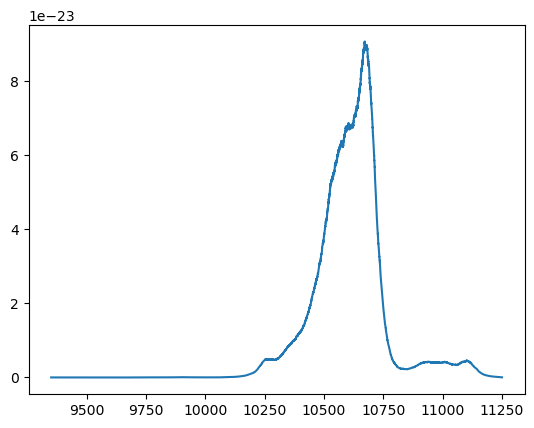

In [40]:
plt.plot(np.array(gas_abs_data_h2o)[0], spectrum[0])

## 6. Exporting to file

In [41]:
w_range_start = np.argmin(np.abs(w - left_limit))
w_range_end = np.argmin(np.abs(w - right_limit)) + 1

w_cut = w[w_range_start:w_range_end]
ext_profiles_cut = ext_profiles[:,w_range_start:w_range_end]  #selecting the right range of values

In [42]:
output = np.vstack((w_cut, ext_profiles_cut))

In [43]:
output.shape

(105, 28001)

In [44]:
# plt.plot(w, ext_profiles[0])

In [45]:
# plt.yscale('log')
# plt.plot(w, ext_profiles[0, :])

In [46]:
len(w)

38001

In [47]:
len(w_cut)

28001

In [48]:
print(OUTPUT_PATH + f'gas_ext_CO2_{DATABASE_CO2}_{PROFILE_CO2}_H2O_HDO_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv')

gas_ext/gas_ext_CO2_hot_ames_bezard_H2O_HDO_hitran_foreign_cont_MTCKD_005_9600_11000_104.csv


In [49]:
np.savetxt(OUTPUT_PATH + f'gas_ext_CO2_{DATABASE_CO2}_{PROFILE_CO2}_H2O_HDO_{DATABASE_H2O}_{PROFILE_H2O}_{step_txt}_{left_limit}_{right_limit}_{len(atm)}.csv', output, delimiter=',')